## Create a classifier to predict whether or not a consumer is creditworthy

### Preliminaries

In [1]:
# COMPLETE

# Basic Libraries
import numpy as np # for math computation
import pandas as pd # for data analysis
import matplotlib.pyplot as plt # for plotting

# another plotting package - slightly better visuals than matplot
import seaborn as sns

In [2]:
# Machine Learning Modules from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline

In [3]:
RANDOM_STATE = 200 # seed to recreate results

In [77]:
#Functions for Supervised Classification Performance Metrics

def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) # / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
    plt.show()

### Data Import

In [5]:

credit = pd.read_csv("Credit-MODIFIED.csv", index_col = 0)

NB index_col = 0 tells python we already have an index in the 1st column

### Preliminary Exploratory Data Analysis

In [6]:

credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Eye Color,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Hazel,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Blue,903
3,104.593,7075,514,4,71,11,Male,NaN,No,Blue,580
4,148.924,9504,681,3,36,11,Female,No,No,Blue,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Hazel,331


In [7]:

credit.shape

(400, 11)

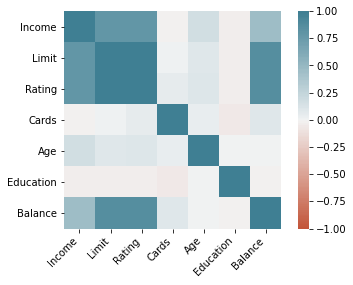

In [8]:
# feature correlation
corr = credit.corr()

#create a heatmap with seaborn
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# x axis labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [9]:
corr

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062
Balance,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000


### Data Wrangling

#### Missing values

In [10]:

credit.isnull().sum() # isna() is same as isnull()

Income        0
Limit         0
Rating        0
Cards         0
Age           0
Education     0
Gender        0
Student      33
Married       0
Eye Color     0
Balance       0
dtype: int64

In [11]:
# 33 missing values in the student column

In [12]:
#  no. of unique values in each column
credit.nunique()

Income       399
Limit        387
Rating       283
Cards          9
Age           68
Education     16
Gender         2
Student        2
Married        2
Eye Color      3
Balance      284
dtype: int64

<AxesSubplot:>

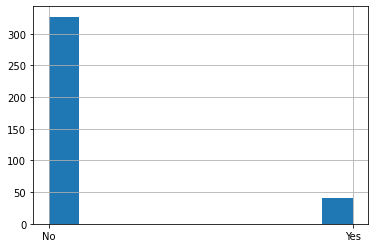

In [13]:

# the distribution of this column ?
credit.Student.hist()

In [14]:
# aside - we can also breakdwon the relative proportion of values in a column
# using value_counts()
credit.Student.value_counts()

No     327
Yes     40
Name: Student, dtype: int64

In [15]:
# so student column is predominantly "no" - lets asssume "no" as a proxy for the missing values
# COMPLETE
credit.loc[:,"Student"].replace(np.nan,"No", inplace=True)

NB np.nan means missing values, inplace = True means overwrite my dataframe

In [16]:

#just to check that was implemented
credit.isnull().sum()

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Gender       0
Student      0
Married      0
Eye Color    0
Balance      0
dtype: int64

#### Encoding

In [17]:
credit_ = credit.copy() # taking a copy/backup of our original dataframe in case we have errors
# later in your notebook (i.e. for debugging/troubleshooting)

# COMPLETE - replace values in the student column with 0s and 1s
credit_.Student = credit_.Student.map(lambda student: 1 if student == "Yes" else 0)

In [18]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Eye Color,Balance
1,14.891,3606,283,2,34,11,Male,0,Yes,Hazel,333
2,106.025,6645,483,3,82,15,Female,1,Yes,Blue,903
3,104.593,7075,514,4,71,11,Male,0,No,Blue,580
4,148.924,9504,681,3,36,11,Female,0,No,Blue,964
5,55.882,4897,357,2,68,16,Male,0,Yes,Hazel,331


In [19]:
# encoding the mmarried category status
credit_.Married = credit_.Married.map(lambda married: 1 if married == "Yes" else 0)

In [20]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Eye Color,Balance
1,14.891,3606,283,2,34,11,Male,0,1,Hazel,333
2,106.025,6645,483,3,82,15,Female,1,1,Blue,903
3,104.593,7075,514,4,71,11,Male,0,0,Blue,580
4,148.924,9504,681,3,36,11,Female,0,0,Blue,964
5,55.882,4897,357,2,68,16,Male,0,1,Hazel,331


In [21]:
# encoding the gender category ststus
credit_["Female"] = credit_.Gender.map(lambda gender: 1 if gender == "Female" else 0)

In [22]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Eye Color,Balance,Female
1,14.891,3606,283,2,34,11,Male,0,1,Hazel,333,0
2,106.025,6645,483,3,82,15,Female,1,1,Blue,903,1
3,104.593,7075,514,4,71,11,Male,0,0,Blue,580,0
4,148.924,9504,681,3,36,11,Female,0,0,Blue,964,1
5,55.882,4897,357,2,68,16,Male,0,1,Hazel,331,0


In [23]:
# COMPLETE - one hot encoding
# the normal way to do one hot encoding is using the function "get_dummies"

eye_color = pd.get_dummies(credit["Eye Color"], drop_first=True) # drop_first drops the 
# first column created from the first (alphabetically) value in the eye_colour column 
# so in our case it will drop the "blue" column

credit_ = pd.concat([credit_.drop("Eye Color", axis=1), eye_color], axis=1)
#NB axis = 1 tells python to drop "columns" (axis = 0 would be rows)

NB pd.concat CONCATENATES two pandas dataframes - in this case the credit_ main dataframe 
(minus the eye_color column) with the green and hazel columns

In [24]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Female,Green,Hazel
1,14.891,3606,283,2,34,11,Male,0,1,333,0,0,1
2,106.025,6645,483,3,82,15,Female,1,1,903,1,0,0
3,104.593,7075,514,4,71,11,Male,0,0,580,0,0,0
4,148.924,9504,681,3,36,11,Female,0,0,964,1,0,0
5,55.882,4897,357,2,68,16,Male,0,1,331,0,0,1


In [25]:
# drop the gender column
credit_.drop("Gender", axis=1, inplace = True) # inplace = True means replace the source dataframe

In [26]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Female,Green,Hazel
1,14.891,3606,283,2,34,11,0,1,333,0,0,1
2,106.025,6645,483,3,82,15,1,1,903,1,0,0
3,104.593,7075,514,4,71,11,0,0,580,0,0,0
4,148.924,9504,681,3,36,11,0,0,964,1,0,0
5,55.882,4897,357,2,68,16,0,1,331,0,0,1


#### Feature Engineering

we dont have a NATURAL LABEL in our data, but we can use the rating column to synthetically
create one...

In [27]:
# we now define a creditworthy person as someone who has a credit score (rating) of over 600
# COMPLETE
credit_["Creditworthy"] = credit_.Rating.map(lambda val: 0 if val < 600 else 1)

In [28]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Female,Green,Hazel,Creditworthy
1,14.891,3606,283,2,34,11,0,1,333,0,0,1,0
2,106.025,6645,483,3,82,15,1,1,903,1,0,0,0
3,104.593,7075,514,4,71,11,0,0,580,0,0,0,0
4,148.924,9504,681,3,36,11,0,0,964,1,0,0,1
5,55.882,4897,357,2,68,16,0,1,331,0,0,1,0


In [30]:
# 1) drop the Rating column
credit_.drop("Rating", axis=1, inplace = True) 

In [31]:
credit_.head() # check to see if implemented correctly

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Female,Green,Hazel,Creditworthy
1,14.891,3606,2,34,11,0,1,333,0,0,1,0
2,106.025,6645,3,82,15,1,1,903,1,0,0,0
3,104.593,7075,4,71,11,0,0,580,0,0,0,0
4,148.924,9504,3,36,11,0,0,964,1,0,0,1
5,55.882,4897,2,68,16,0,1,331,0,0,1,0


<AxesSubplot:>

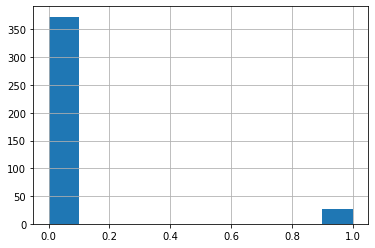

In [32]:
# 2) plot the distribution of the new TARGET variable (i.e. the LABEL)
credit_.Creditworthy.hist()

In [33]:
credit_.Creditworthy.value_counts()

0    373
1     27
Name: Creditworthy, dtype: int64

when we have a strong majority "classification" such as this on the TARGET variable, 
we call this an imbalanced dataset

### Training/test split/harness (Data Partitioning)

In [34]:
# COMPLETE - we first define X (our features) and y (target)
X = credit_.loc[:, credit_.columns != "Creditworthy"] # the loc function uses [rows, cols]
# NB ":" on its own means ALL THE ROWS, "!=" is NOT equal to
y = credit_["Creditworthy"] # y is our TARGET variable

In [35]:
# Exercise - use google to apply a function to X and y in order to split our data into 
# a training and test set for machine learning modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

In [36]:
# check the split / partitioning
X_train.shape

(200, 11)

so 200 rows and 11 columns

In [37]:
X_test.shape

(200, 11)

In [38]:
y_test.shape

(200,)

### Fit model - (Logistic Regression)

#### Method 0

In [39]:
# fit a model to all features
estimator = LogisticRegression(random_state = RANDOM_STATE) # STEP 1: setting up the ML algo
estimator.fit(X_train, y_train) # STEP 2: fit the model on the TRAINING data

y_true = y_test # STEP 3 (optional): variable name change

y_pred = estimator.predict(X_test) # STEP 4: predict using the TEST set features
y_score = estimator.predict_proba(X_test)[:,0] # STEP 5 (optional): 
# extract the classification probabilities in order to plot a ROC curve later

C:\Users\bwals\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pink messages are warnings - typically a DEPRECATION warning about a library change in the future

### Performance Metrics

In [41]:
# COMPLETE
accuracy_score(y_true, y_pred) # the most basic performance measure

0.96

In [42]:
recall_score(y_true, y_pred)

0.8181818181818182

In [43]:
precision_score(y_true, y_pred)

0.6

all above metrics are measured from zero to one

#### Method 1

In [44]:
# feature selection - here we only use a shortlist of features 
# typically in ML we make a hypothesis after a few runs as to which FEATURES are
# likely ot be our best predictors

X = credit_[["Age","Education", "Student", "Married"]]
y = credit_["Creditworthy"]

In [45]:
# partition the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

In [46]:
X_train.shape

(200, 4)

In [48]:
# a) have a go at fitting the model 
# b) and make new predictions

# fit a model to all features
estimator = LogisticRegression(random_state = RANDOM_STATE) # STEP 1: setting up the ML algo
estimator.fit(X_train, y_train) # STEP 2: fit the model on the TRAINING data

y_true = y_test # STEP 3 (optional): variable name change

y_pred = estimator.predict(X_test) # STEP 4: predict using the TEST set features
y_score = estimator.predict_proba(X_test)[:,0] # STEP 5 (optional): 
# extract the classification probabilities in order to plot a ROC curve later

In [49]:
accuracy_score(y_true, y_pred)

0.945

In [50]:
recall_score(y_true, y_pred)

0.0

In [51]:
precision_score(y_true, y_pred)

C:\Users\bwals\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [52]:
# confusion matrix
confusion_matrix(y_true,y_pred)

array([[189,   0],
       [ 11,   0]], dtype=int64)

In [53]:
# this doesnt look good - only 11 creditworthy cases - and all "False Negatives" 

#### Method 2

In [54]:
# lets make a small change to our features
X = credit_[["Income","Education", "Student", "Married"]]
y = credit_["Creditworthy"]

In [55]:
# partition the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

In [56]:
# fit a model to all features
estimator = LogisticRegression(random_state = RANDOM_STATE) # STEP 1: setting up the ML algo
estimator.fit(X_train, y_train) # STEP 2: fit the model on the TRAINING data

y_true = y_test # STEP 3 (optional): variable name change

y_pred = estimator.predict(X_test) # STEP 4: predict using the TEST set features
y_score = estimator.predict_proba(X_test)[:,0] # STEP 5 (optional): 
# extract the classification probabilities in order to plot a ROC curve later

In [57]:
accuracy_score(y_true, y_pred)

0.95

In [58]:
recall_score(y_true, y_pred)

0.8181818181818182

In [59]:
precision_score(y_true, y_pred)

0.5294117647058824

In [60]:
confusion_matrix(y_true,y_pred)

array([[181,   8],
       [  2,   9]], dtype=int64)

#### Method 3

In [61]:
# here we try using hyperparameters to improve results

# we define here a dictionary of model hyperparameter "penalties" which either constrain or 
# relax our model. GOAL is to improve the model "fit". C is a "regularization" parameter,
# while l1, l2 are alternative logistic regression methods
param_grid = dict(C=[0.00001,0.0001,0.001,0.01,0.1,1,10],penalty=['l1','l2'])

regr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear') # defining our model

# set up "grid search" - a means to run multiple (14 in this case) configurations of our hyperparameters
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision')
cv.fit(X_train, y_train) # fit the model
estimator = cv.best_estimator_ # extract the best configuration of hyperparameters

# same as method 0,1 and 2
y_true = y_test  # 3
y_pred = estimator.predict(X_test)  # 4
y_score = estimator.predict_proba(X_test)[:, 0]  # 5

In [62]:
accuracy_score(y_true, y_pred) # same as method 0, 1 and 2

0.96

In [63]:
recall_score(y_true, y_pred) # same as method 0, 1 and 2

0.7272727272727273

In [64]:
precision_score(y_true, y_pred) # same as method 0, 1 and 2

0.6153846153846154

In [65]:
confusion_matrix(y_true,y_pred) # same as method 0, 1 and 2

array([[184,   5],
       [  3,   8]], dtype=int64)

#### Method 4

In [70]:
# we try one more time, this time as well as hyperparameters we SCALE our data
scaler = StandardScaler() # scaling function

#same three lines below for grid search acroos hyperparameters C and penalty as in Method 3
param_grid = dict(C=[0.00001,0.0001,0.001,0.01,0.1,1,10],penalty=['l1','l2']) # same as method 3
regr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear') # 1
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision') # same as method 3

pipeline = make_pipeline(scaler, cv) # here we SCALE the data so that all features are in the same "ballpark"

pipeline.fit(X_train, y_train) # 2 fit the model to the SCALED data

y_true = y_test # 3
y_pred = pipeline.predict(X_test) # 4
y_score = pipeline.predict_proba(X_test)[:, 1] # 5

In [72]:
accuracy_score(y_true, y_pred) # same as method 0, 1 and 2

0.97

In [73]:
recall_score(y_true, y_pred) # same as method 0, 1 and 2

0.7272727272727273

In [74]:
precision_score(y_true, y_pred) # same as method 0, 1 and 2

0.7272727272727273

In [75]:
confusion_matrix(y_true,y_pred) # same as method 0, 1 and 2

array([[186,   3],
       [  3,   8]], dtype=int64)

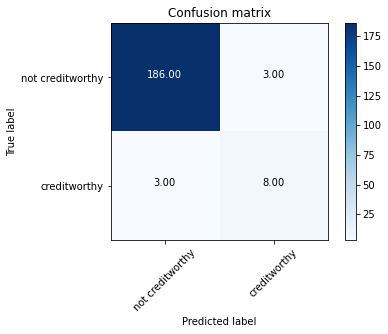

In [78]:
# plotting a confusion matrix
plot_confusion_matrix(confusion_matrix(y_true,y_pred), ["not creditworthy", "creditworthy"])

### Additional Performance Metrics

In [79]:
# Exercise - Classification Report (make use of google)
print(classification_report(y_true, y_pred, target_names=["not creditworthy", "creditworthy"]))

                  precision    recall  f1-score   support

not creditworthy       0.98      0.98      0.98       189
    creditworthy       0.73      0.73      0.73        11

        accuracy                           0.97       200
       macro avg       0.86      0.86      0.86       200
    weighted avg       0.97      0.97      0.97       200



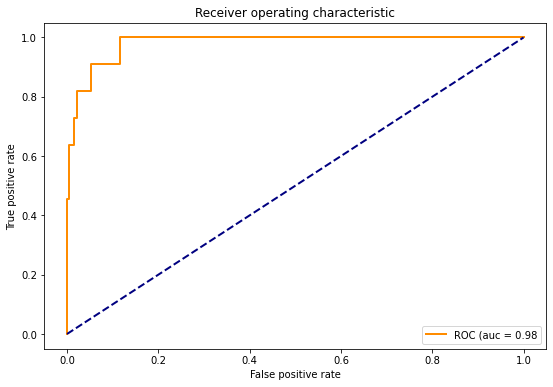

In [80]:
# Exercise - ROC Curve (use the other function)
plot_roc_curve(y_true, y_score)

### Parallel Model Runs

C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR: 0.972500 (0.023585)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LDA: 0.962500 (0.025617)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


KNN: 0.970000 (0.018708)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


CART: 0.940000 (0.037417)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


RF: 0.967500 (0.019526)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


NB: 0.962500 (0.025617)


C:\Users\bwals\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


SVM: 0.967500 (0.022500)


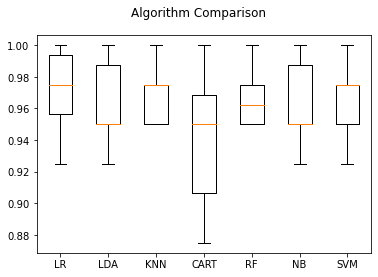

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import model_selection

# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier())) # NB NOT KMeans (unsupervised)
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB())) # Naive Bayes
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []

scoring = 'accuracy' # or, better still fbeta
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()